Step 1. Importing all libries 

In [29]:
# Data Handling & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


2: Load Dataset

In [43]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell X (new “All-in-One Encoding & Clean” cell)
# ─────────────────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np

# 1. Load original raw CSV
df = pd.read_csv("data/bank-additional-full.csv", sep=";")

# 2. Replace any "unknown" with NaN
df.replace("unknown", np.nan, inplace=True)

# 3. Impute all categorical missing values with mode
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    df[col] = df[col].fillna(df[col].mode()[0])

# 4. One-hot encode ALL categorical columns (including month, day_of_week, contact, poutcome)
#    and drop the first level to avoid redundant columns. 
#    Leave 'y' untouched for now.
cat_cols = ['job', 'marital', 'education', 'default', 
            'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 5. Encode target column 'y' to 0/1
df_encoded['y'] = df['y'].map({'no': 0, 'yes': 1})

# 6. Confirm there are no object dtypes remaining:
print("➡️ dtypes after encoding:", df_encoded.dtypes.value_counts())

# 7. (Same as before) Drop highly correlated features if necessary:
#    Compute correlation matrix and drop 'emp.var.rate' and 'nr.employed'
corr_matrix = df_encoded.corr(numeric_only=True)
mask_upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr = (corr_matrix.where(mask_upper)
             .stack()
             .reset_index()
             .rename(columns={'level_0': 'f1', 'level_1': 'f2', 0: 'corr'}))
high_corr = high_corr.loc[high_corr['corr'].abs() > 0.85]

print("➡️ Highly correlated pairs (|corr|>0.85):")
print(high_corr)

# If the same three remain, drop 'emp.var.rate' and 'nr.employed'
df_final = df_encoded.drop(columns=['emp.var.rate', 'nr.employed'], errors='ignore')

print("➡️ Final DataFrame shape:", df_final.shape)
print("➡️ dtypes after dropping:", df_final.dtypes.value_counts())


➡️ dtypes after encoding: bool       37
int64       6
float64     5
Name: count, dtype: int64
➡️ Highly correlated pairs (|corr|>0.85):
               f1                    f2      corr
181         pdays      poutcome_success -0.950700
223      previous  poutcome_nonexistent -0.878776
227  emp.var.rate             euribor3m  0.972245
228  emp.var.rate           nr.employed  0.906970
348     euribor3m           nr.employed  0.945154
➡️ Final DataFrame shape: (41188, 46)
➡️ dtypes after dropping: bool       37
int64       6
float64     3
Name: count, dtype: int64


Train the model again

In [44]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell: Re-Split & Save Pickle Splits (Member 1)
# ─────────────────────────────────────────────────────────────────────────────

from sklearn.model_selection import train_test_split
import pickle

# Separate features and target
X = df_final.drop("y", axis=1)
y = df_final["y"]

print("➡️ X shape:", X.shape, "| y shape:", y.shape)

# 80/20 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("➡️ X_train:", X_train.shape, "| y_train:", y_train.shape)
print("➡️ X_test :", X_test.shape,  "| y_test :", y_test.shape)

# Save to disk as .pkl
with open("X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
with open("X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)
with open("y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)
with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("✅ Saved new pickle splits.")


➡️ X shape: (41188, 45) | y shape: (41188,)
➡️ X_train: (32950, 45) | y_train: (32950,)
➡️ X_test : (8238, 45) | y_test : (8238,)
✅ Saved new pickle splits.


all cells below sebjected to correction later

In [ ]:
# Load the dataset (update filename if different)
df = pd.read_csv('data/bank-additional-full.csv', sep=';')

# Preview
df.head()


3: Inspect Dataset Structure

In [ ]:
# View dimensions
print("Dataset shape:", df.shape)

# Check data types and non-null counts
print("\n--- DataFrame Info ---")
df.info()

# Summary statistics (numerical + categorical)
print("\n--- Descriptive Statistics (including categorical) ---")
display(df.describe(include='all'))

# Check missing values
print("\n--- Missing Values Count ---")
print(df.isnull().sum())

# Preview unique values in some key categorical columns
print("\n--- Unique Values in 'job', 'education', 'poutcome' ---")
print("job:", df['job'].unique())
print("education:", df['education'].unique())
print("poutcome:", df['poutcome'].unique())


4 – Replace "unknown" with NaN and summarize

In [ ]:
import numpy as np

# Replace 'unknown' with np.nan
df.replace("unknown", np.nan, inplace=True)

# Check missing values again
print("Missing values after replacing 'unknown':\n")
print(df.isnull().sum())

# Optional: percentage of missing per column
print("\nPercentage of missing values per column:\n")
print((df.isnull().sum() / len(df) * 100).round(2))


5 – Impute Missing Values

In [ ]:
# Fill categorical columns with mode (safe method)
for col in ['education', 'job', 'marital', 'housing', 'loan']:
    df[col] = df[col].fillna(df[col].mode()[0])

# For 'default', fill with mode safely
df['default'] = df['default'].fillna(df['default'].mode()[0])

# Confirm no missing values
print("✅ Missing values after imputation:\n")
print(df.isnull().sum())


6 – Encode Categorical Variables

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the DataFrame to preserve the original
df_encoded = df.copy()

# Binary columns: encode with LabelEncoder
binary_cols = ['default', 'housing', 'loan', 'y']
le = LabelEncoder()
for col in binary_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# One-hot encode all other categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=[
    'job', 'marital', 'education', 'contact', 
    'month', 'day_of_week', 'poutcome'
], drop_first=True)

# Show result
print("✅ Categorical variables encoded.")
print("Encoded DataFrame shape:", df_encoded.shape)


 7 – Encode Target + Correlation Analysis + Feature Insight

✅ Target variable encoded.



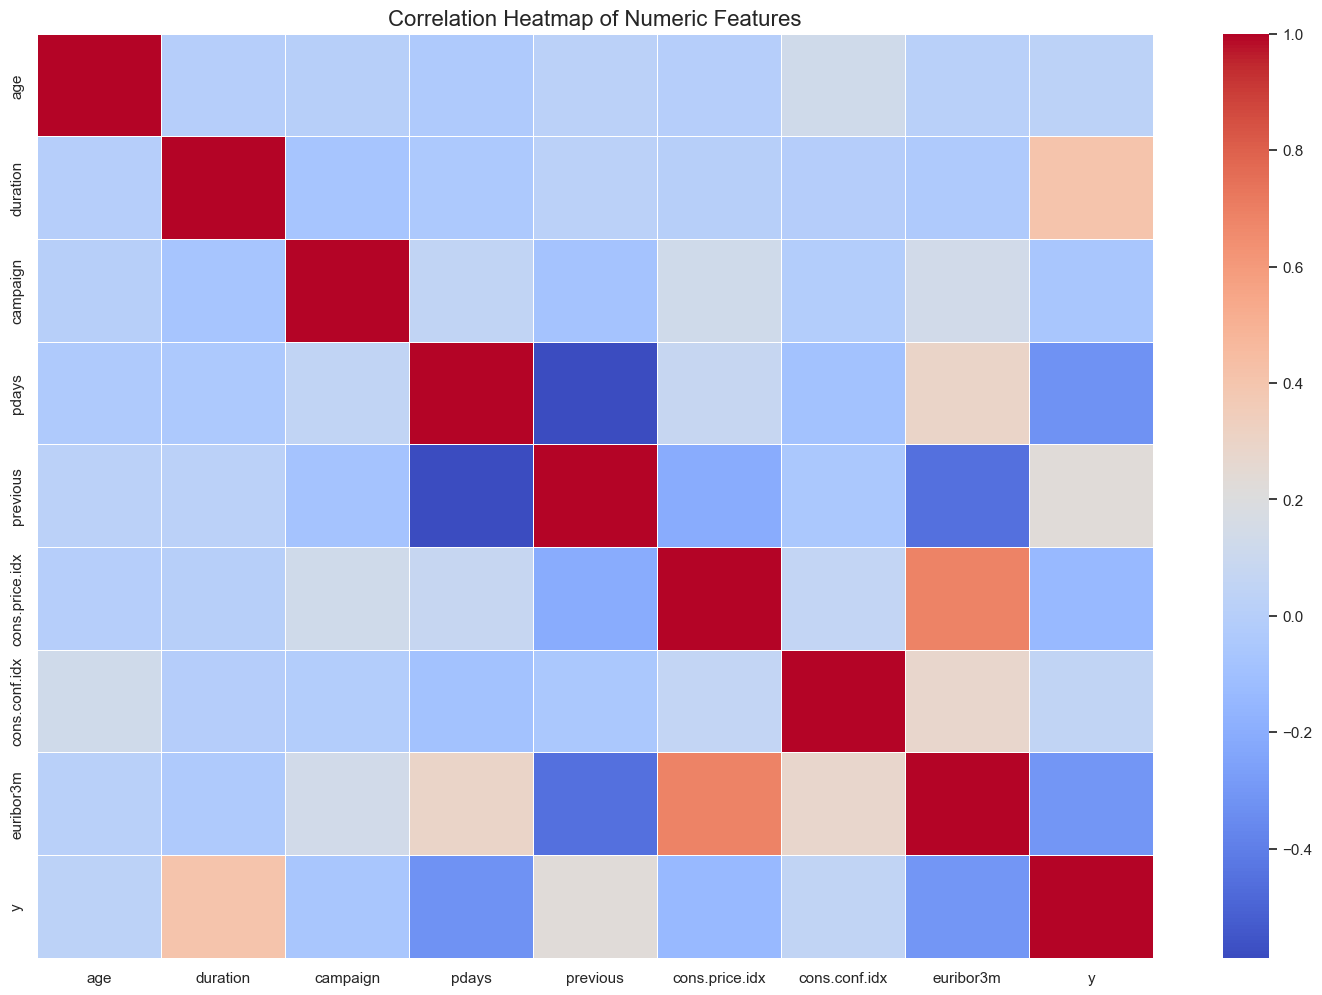


✅ No highly correlated feature pairs above threshold (0.85).


In [40]:
# Encode target variable 'y' to binary (1 for 'yes', 0 for 'no')
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded['y'] = df['y'].map({'no': 0, 'yes': 1})

print("✅ Target variable encoded.\n")

# Optional: Correlation matrix (numeric columns only)
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()

# Optional: Identify highly correlated pairs
threshold = 0.85
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs = high_corr_pairs.loc[high_corr_pairs['Correlation'].abs() > threshold]

# Print high correlation pairs (for potential feature reduction)
if not high_corr_pairs.empty:
    print("\n⚠️ Highly correlated features (|corr| > 0.85):")
    print(high_corr_pairs.sort_values(by='Correlation', ascending=False))
else:
    print("\n✅ No highly correlated feature pairs above threshold (0.85).")


DROPPING HIGHLY CORRELATED FEATURES 

8. TRAINING THE MODEL